In [1]:
import sys
import os
import pandas as pd
# If running in an environment where __file__ is not defined, manually set the path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(project_dir, 'src'))

from clean import handle_missing_values, convert_to_datetime, calculate_trip_duration, calculate_iqr_bounds, remove_outliers, drop_columns_with_missing_values, detect_outliers
from add_holiday import add_holiday_feature
from fetch_weather import fetch_weather_data
from extract_feature import normalize_features, compute_additional_features

In [2]:

# Load datasets
completed_orders = pd.read_csv('../data/nb.csv')
delivery_requests = pd.read_csv('../data/driver_locations_during_request.csv')


In [3]:
print(completed_orders.head())

   Trip ID                         Trip Origin  \
0   391996  6.508813001668548,3.37740316890347   
1   391997                 6.4316714,3.4555375   
2   391998         6.631679399999999,3.3388976   
3   391999         6.572757200000001,3.3677082   
4   392001                 6.6010417,3.2766339   

                  Trip Destination      Trip Start Time        Trip End Time  
0      6.650969799999999,3.3450307  2021-07-01 07:28:04  2021-07-01 07:29:37  
1  6.4280814653326,3.4721885847586  2021-07-01 06:38:04  2021-07-01 07:07:28  
2      6.508324099999999,3.3590397  2021-07-01 06:21:02  2021-07-01 07:02:23  
3      6.584881099999999,3.3614073  2021-07-01 07:16:07  2021-07-01 07:29:42  
4              6.4501069,3.3916154  2021-07-01 09:30:59  2021-07-01 09:34:36  


In [4]:
#check missing values for order
print(completed_orders.isnull().sum())

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          1
dtype: int64


In [5]:

# Handle missing values
completed_orders = handle_missing_values(completed_orders, ['Trip Start Time', 'Trip End Time'])



In [6]:
#check missing values for order
print(completed_orders.isnull().sum())

Trip ID             0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
dtype: int64


In [7]:

# Convert to datetime
completed_orders = convert_to_datetime(completed_orders, ['Trip Start Time', 'Trip End Time'])

# Calculate trip duration
completed_orders = calculate_trip_duration(completed_orders, 'Trip Start Time', 'Trip End Time')

# Calculate IQR bounds
lower_bound, upper_bound = calculate_iqr_bounds(completed_orders, 'trip_duration')
# Detect outliers
outliers_iqr = detect_outliers(completed_orders, 'trip_duration', lower_bound, upper_bound)

# Remove outliers
completed_orders_no_outliers = remove_outliers(completed_orders, 'trip_duration', lower_bound, upper_bound)


In [8]:

# Drop columns with completely missing values in delivery_requests
delivery_requests = drop_columns_with_missing_values(delivery_requests, ['created_at', 'updated_at'])

In [9]:
# check few rows of delivery request
delivery_requests.head()
# print(delivery_requests.info())


,id,order_id,driver_id,driver_action,lat,lng
0,1,392001,243828,accepted,6.602207,3.270465
1,2,392001,243588,rejected,6.592097,3.287445
2,3,392001,243830,rejected,6.596133,3.281784
3,4,392001,243539,rejected,6.596142,3.280526
4,5,392001,171653,rejected,6.609232,3.288800


In [10]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

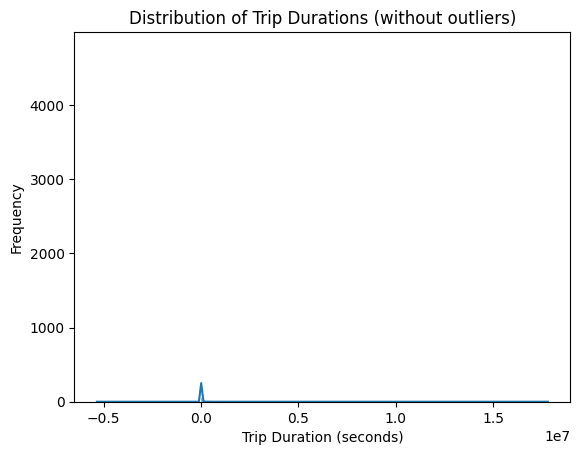

In [11]:
# Visualize the distribution of trip durations without outliers
sns.histplot(outliers_iqr['trip_duration'], kde=True)
plt.title('Distribution of Trip Durations (without outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

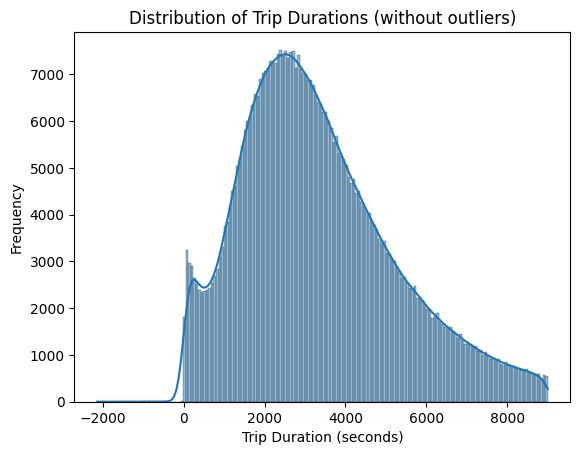

In [12]:
# Visualize the distribution of trip durations without outliers
sns.histplot(completed_orders_no_outliers['trip_duration'], kde=True)
plt.title('Distribution of Trip Durations (without outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


In [13]:
# check missing values for delivery
print(delivery_requests.isnull().sum())


id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64


In [14]:
# Add holiday feature
completed_orders = add_holiday_feature(completed_orders)

Completed adding holiday feature.


In [15]:
completed_orders.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,trip_duration,is_holiday
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,93.0,False
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,1764.0,False
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,2481.0,False
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,815.0,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,217.0,False


In [16]:
# Extract latitude and longitude from Trip Origin and Trip Destination
completed_orders[['Trip Origin Lat', 'Trip Origin Lng']] = completed_orders['Trip Origin'].str.split(',', expand=True).astype(float)
completed_orders[['Trip Destination Lat', 'Trip Destination Lng']] = completed_orders['Trip Destination'].str.split(',', expand=True).astype(float)


In [17]:

# Fetch weather data
# completed_orders = fetch_weather_data(completed_orders)

In [18]:
# Add additional features
completed_orders['hour'] = completed_orders['Trip Start Time'].dt.hour
completed_orders['day_of_week'] = completed_orders['Trip Start Time'].dt.dayofweek
completed_orders['is_weekend'] = completed_orders['day_of_week'] >= 5

In [19]:
print(completed_orders.columns)

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'trip_duration', 'is_holiday', 'Trip Origin Lat',
       'Trip Origin Lng', 'Trip Destination Lat', 'Trip Destination Lng',
       'hour', 'day_of_week', 'is_weekend'],
      dtype='object')


# Next Step...

In [20]:
from extract_feature import compute_additional_features, clean_features, count_orders_within_radius,compute_clusters

In [21]:

# Compute additional features
completed_orders = compute_additional_features(completed_orders)
print("Columns after computing additional features:", completed_orders.columns)


Columns after computing additional features: Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'trip_duration', 'is_holiday', 'Trip Origin Lat',
       'Trip Origin Lng', 'Trip Destination Lat', 'Trip Destination Lng',
       'hour', 'day_of_week', 'is_weekend', 'distance_km',
       'driving_speed_kmph'],
      dtype='object')


In [22]:
# very unusual values in your data before clean feature

# Normalize selected features
features_to_normalize = ['trip_duration', 'distance_km', 'driving_speed_kmph']
print("Columns before normalization:", completed_orders.columns)
completed_orders = normalize_features(completed_orders, features_to_normalize)

Columns before normalization: Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'trip_duration', 'is_holiday', 'Trip Origin Lat',
       'Trip Origin Lng', 'Trip Destination Lat', 'Trip Destination Lng',
       'hour', 'day_of_week', 'is_weekend', 'distance_km',
       'driving_speed_kmph'],
      dtype='object')
Summary statistics before filling NaNs:
       trip_duration    distance_km  driving_speed_kmph
count   5.360200e+05  536020.000000       536015.000000
mean    4.992324e+03      12.096344           26.525928
std     5.250765e+04      11.048909          245.068922
min    -5.339356e+06       0.000000        -7156.733045
25%     2.022000e+03       5.538559            6.853479
50%     3.180000e+03      10.508526           11.132455
75%     4.817000e+03      17.009161           16.827735
max     1.781371e+07     682.877403        66790.115237
Number of NaNs in each column before filling:
trip_duration         0
distance_km           0
d

Note: From the summary statistics, it's clear that there are some very unusual values in your data. Specifically, the trip_duration has negative values and extremely large values, which are unrealistic. Similarly, driving_speed_kmph has negative and extremely high values.

In [23]:

# Clean features
completed_orders = clean_features(completed_orders)

In [24]:
# after clean feature
# Normalize selected features
features_to_normalize = ['trip_duration', 'distance_km', 'driving_speed_kmph']
print("Columns before normalization:", completed_orders.columns)
completed_orders = normalize_features(completed_orders, features_to_normalize)

Columns before normalization: Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'trip_duration', 'is_holiday', 'Trip Origin Lat',
       'Trip Origin Lng', 'Trip Destination Lat', 'Trip Destination Lng',
       'hour', 'day_of_week', 'is_weekend', 'distance_km',
       'driving_speed_kmph'],
      dtype='object')
Summary statistics before filling NaNs:


       trip_duration  distance_km  driving_speed_kmph
count     222.000000   222.000000          222.000000
mean        0.032241     7.816243            0.098714
std         0.088776    14.580829            0.315508
min         0.000146     2.269986            0.000012
25%         0.006898     2.778274            0.004292
50%         0.015106     3.326853            0.011239
75%         0.033551     4.388194            0.024418
max         1.035235    60.583286            1.808215
Number of NaNs in each column before filling:
trip_duration         0
distance_km           0
driving_speed_kmph    0
dtype: int64
Number of NaNs in each column after filling:
trip_duration         0
distance_km           0
driving_speed_kmph    0
dtype: int64


In [25]:
# Compute the number of riders and orders within 500m
delivery_requests = count_orders_within_radius(delivery_requests, radius=0.5)

In [ ]:

# Print summary of the new radius-based features
total_accepted_within_radius = delivery_requests['accepted_within_radius'].sum()
total_unfulfilled_within_radius = delivery_requests['unfulfilled_within_radius'].sum()


In [ ]:

print(f"Total accepted orders within 500m radius: {total_accepted_within_radius}")
print(f"Total unfulfilled orders within 500m radius: {total_unfulfilled_within_radius}")


Total accepted orders within 500m radius: 264
Total unfulfilled orders within 500m radius: 226


In [ ]:
# Compute clusters for origins and destinations
completed_orders, kmeans_origin, kmeans_destination = compute_clusters(completed_orders, n_clusters=10)


In [ ]:
# def plot_clusters(df, kmeans, lat_col, lng_col, cluster_col, title):
#     """
#     Plot clusters on a scatter plot.
#     """
#     plt.figure(figsize=(12, 8))
#     plt.scatter(df[lat_col], df[lng_col], c=df[cluster_col], cmap='viridis', marker='o', alpha=0.6, s=100)
#     plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
#     plt.title(title)
#     plt.xlabel('Latitude')
#     plt.ylabel('Longitude')
#     plt.grid(True)
#     plt.show()


In [ ]:

# # Plot clusters for trip origins
# plot_clusters(completed_orders, kmeans_origin, 'Trip Origin Lat', 'Trip Origin Lng', 'origin_cluster', 'Clusters of Trip Origins')

# # Plot clusters for trip destinations
# plot_clusters(completed_orders, kmeans_destination, 'Trip Destination Lat', 'Trip Destination Lng', 'destination_cluster', 'Clusters of Trip Destinations')


In [ ]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import holoviews as hv
import geoviews as gv
from holoviews.operation.datashader import datashade
from datashader.utils import export_image
from sklearn.cluster import KMeans

/home/air/.pyenv/versions/3.10.2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:

import datashader as ds
import datashader.transfer_functions as tf
from datashader import reductions
from datashader.utils import export_image
from datashader.mpl_ext import dsshow
import colorcet as cc


In [ ]:

def plot_clusters_with_datashader(df, lat_col, lng_col, title):
    """
    Plot clusters using datashader.
    """
    cvs = ds.Canvas(plot_width=850, plot_height=500)
    agg = cvs.points(df, lng_col, lat_col)
    img = tf.shade(agg, cmap=cc.fire, how='log')
    return img


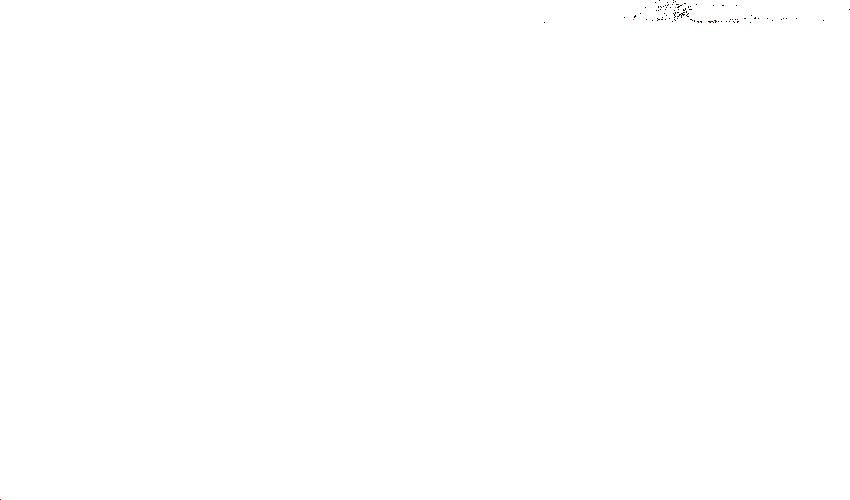

In [ ]:

# Plot clusters for trip origins using datashader
img_origins = plot_clusters_with_datashader(completed_orders, 'Trip Origin Lat', 'Trip Origin Lng', 'Clusters of Trip Origins')
img_origins


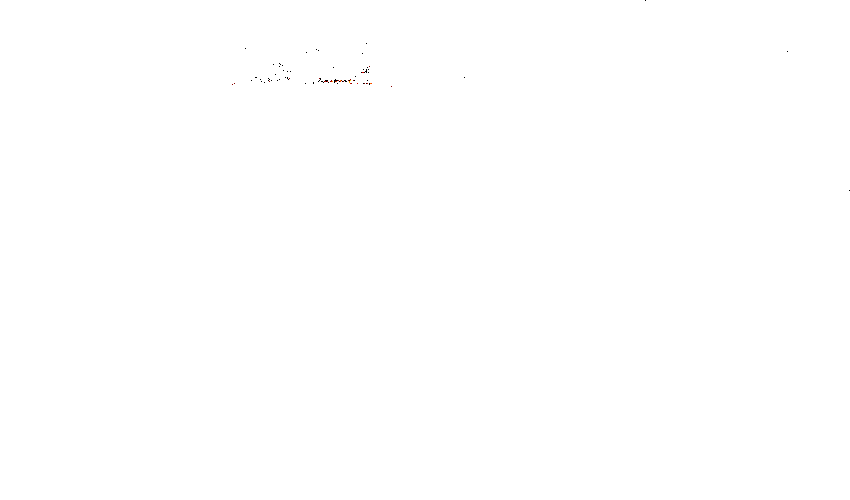

In [ ]:
# Plot clusters for trip destinations using datashader
img_destinations = plot_clusters_with_datashader(completed_orders, 'Trip Destination Lat', 'Trip Destination Lng', 'Clusters of Trip Destinations')
img_destinations
